# **Задача классификации. Вероятностный алгоритм**

Этот набор данных изначально получен из Национального института диабета, болезней органов пищеварения и почек. Целью набора данных является диагностическое **предсказание наличия у пациента диабета** на основе определенных диагностических измерений, включенных в набор данных. На выбор этих экземпляров из большей базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года индейского происхождения пима.

Из набора данных в файле (.csv) мы можем найти несколько переменных, некоторые из них являются независимыми (несколько переменных медицинских предикторов) и только одна целевая зависимая переменная (**Outcome**).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier #буду использовать случайный лес, составленный из дерева решений

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_control.csv', delimiter = ',')
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [5]:
df_cut = df[['Pregnancies', 'Glucose', 'SkinThickness', 'DiabetesPedigreeFunction', 'Outcome']]
df_cut = df_cut.dropna()

Для исследования в рамках данного блокнота беру следующие столбцы и привожу их 
описание:
*   **Pregnancies:** to express the Number of pregnancies
*   **Glucose:** to express the Glucose level in blood
*   **SkinThickness:** to express the thickness of the skin
*   **DiabetesPedigreeFunction:** to express the Diabetes percentage
*   **Outcome:** to express the final result 1 is Yes and 0 is No

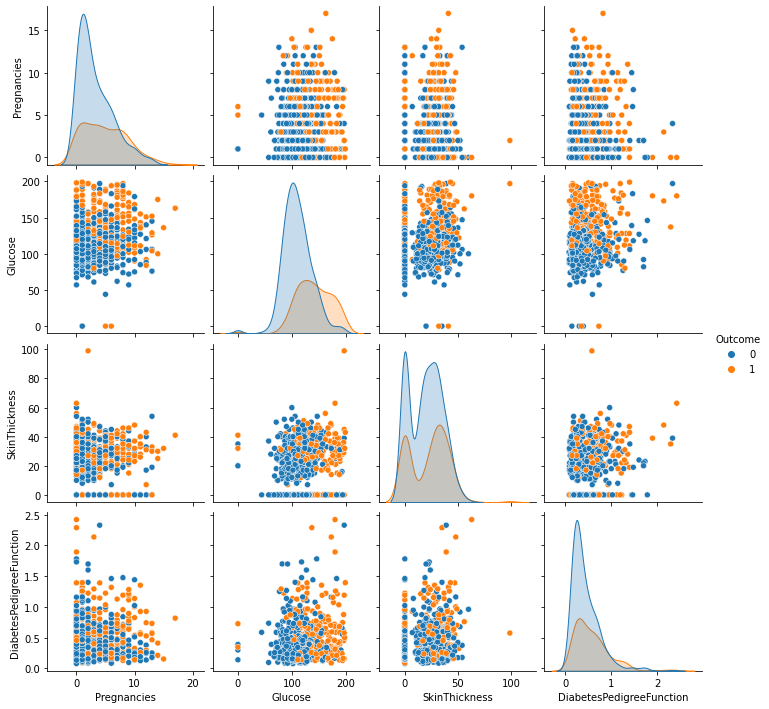

In [6]:
sns.pairplot(df_cut, hue = 'Outcome')

**Идея: можно запустить один из известных алгоритмов, но попросить его выдать вероятности.**

In [9]:
model = RandomForestClassifier(max_depth = 2, random_state = 0) #пеньки глубины два
model.fit(df_cut[['Pregnancies', 'Glucose', 'SkinThickness', 'DiabetesPedigreeFunction']].values.reshape(-1,4), y = df_cut['Outcome'].values)

RandomForestClassifier(max_depth=2, random_state=0)

**Загружаю тестовую выборку:**

In [8]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_control.csv', delimiter = ',')
df_test_cut = df_test[['Pregnancies', 'Glucose', 'SkinThickness', 'DiabetesPedigreeFunction', 'Outcome']]
df_test_cut = df_test_cut.dropna()

**Внимание: здесь нужно вызвать функцию predict_proba, если хотим получить вероятности.**

In [10]:
result = model.predict_proba(df_test_cut[['Pregnancies', 'Glucose', 'SkinThickness', 'DiabetesPedigreeFunction']].values.reshape(-1,4))    #predict probability (предсказать вероятность)
#результат предсказания складываю в таблицу result
print(result)    #это вероятности принадлежности классам

[[0.48903017 0.51096983]
 [0.82158933 0.17841067]
 [0.25982609 0.74017391]
 ...
 [0.75347714 0.24652286]
 [0.59604605 0.40395395]
 [0.67244297 0.32755703]]


**Какой смысл у чисел выше?**

Первая строка относится к 1му объекту тестовой выборки. Для этого объекта сказано, что с веротностью 0.48903017 он принадлежит к одному классу, а с вероятностью 0.51096983 - к другому.

Оформим эти результаты:

In [11]:
#формируем новые столбцы
df_test_cut['pr class 0'] = result[:,0]    #вероятность класса 0, т.е. того, что человек не имеет диабета
df_test_cut['pr class 1'] = result[:,1]    #вероятность класса 1, т.е. того, что у человека диабет
df_test_cut.head()

,Pregnancies,Glucose,SkinThickness,DiabetesPedigreeFunction,Outcome,pr class 0,pr class 1
0,6,148,35,0.627,1,0.489030,0.510970
1,1,85,29,0.351,0,0.821589,0.178411
2,8,183,0,0.672,1,0.259826,0.740174
3,1,89,23,0.167,0,0.838846,0.161154
4,0,137,35,2.288,1,0.511364,0.488636


**Предсказание вероятности, а не точного ответа, позволяет сделать поведение алгоритма более гибким.** Мы можем устанавливать разные пороги и смотреть, какие люди попадают в тот или иной порог.
Например, следующая строчка кода выведет список людей с реальным положительным диагнозом (есть диабет, Outcome = 1), для которых при этом расчитанная вероятность быть больными **<0.5**.

In [13]:
df_test_cut[(df_test_cut['pr class 1'] < 0.5) & (df_test_cut['Outcome'] == 1)].head()

,Pregnancies,Glucose,SkinThickness,DiabetesPedigreeFunction,Outcome,pr class 0,pr class 1
4,0,137,35,2.288,1,0.511364,0.488636
6,3,78,32,0.248,1,0.819044,0.180956
9,8,125,0,0.232,1,0.653330,0.346670
15,7,100,0,0.484,1,0.693955,0.306045
16,0,118,47,0.551,1,0.717863,0.282137


Играя с этим параметром, можно разбить выборку на группы, у которых возрастает или убывает вероятность принадлежности к тому или иному классу.

Более того, можно упорядочить людей по возрастанию или убыванию принадлежности к тому или иному классу. И посмотрим, как с точки зрения иск-го интеллекта (ИИ) будет выглядеть наша популяция. А именно, **упорядочив их по вероятности принадлежности к классу диабет-положительных, мы поймем, какие люди по мнению ИИ считаются более здоровыми.**

In [18]:
df_test_cut.sort_values(by = 'pr class 1', ascending = True).head(50)

,Pregnancies,Glucose,SkinThickness,DiabetesPedigreeFunction,Outcome,pr class 0,pr class 1
75,1,0,20,0.140,0,0.838846,0.161154
438,1,97,15,0.147,0,0.838846,0.161154
3,1,89,23,0.167,0,0.838846,0.161154
240,1,91,24,0.192,0,0.838846,0.161154
331,2,87,16,0.166,0,0.838846,0.161154
149,2,90,17,0.085,0,0.838846,0.161154
96,2,92,28,0.130,0,0.837317,0.162683
225,1,87,27,0.101,0,0.837317,0.162683
514,3,99,19,0.154,0,0.836456,0.163544
629,4,94,22,0.148,0,0.836456,0.163544
